# Exam exercise!

### Planning a telescope observation

Let's build your first Markov Chain! 

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.
- Repeat everything you've done but this time use the stock-market diagram with three phases as shown above. If you've written your code well, you should need minimal modifications.

## Resolution

#### For the weather:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# IMPORTANT
# Markov Chain must be of the form: [p of the first state, p of the second state, ..., p of the last state]
# See example below


def get_next_state(current_state, chain):
    probabilities = list(chain.values())[current_state]
    next_state = np.random.choice(list(chain.keys()), p=probabilities)
    return list(chain.keys()).index(next_state)


def simulate(steps, initial_state, chain):
    count_history = {k: [0] for k, _ in chain.items()}
    ratio_history = {k: [0] for k, _ in chain.items()}

    current_state = initial_state

    for i in range(steps):
        current_state = get_next_state(current_state, chain)

        for k in count_history.keys():
            if current_state == list(chain.keys()).index(k):
                res = count_history[k][-1] + 1
            else: 
                res = count_history[k][-1]
            count_history[k].append(res)
            ratio_history[k].append(res/(i+1))

    return count_history, ratio_history


Sunny days ratio: 0.8326


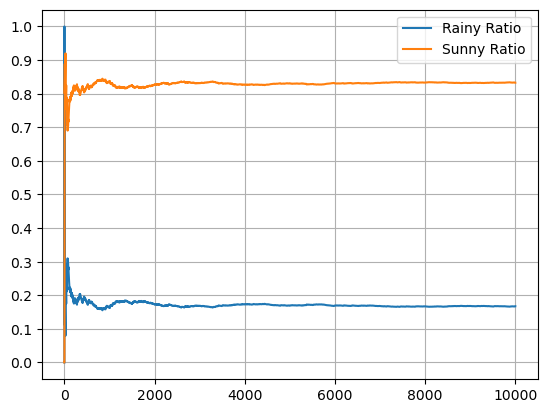

In [4]:
chain = {
    "rainy": [0.5, 0.5], 
    "sunny": [0.1, 0.9],
}

target, ratio = simulate(10000, 0, chain)

# Plotting the ratio results
plt.plot(ratio["rainy"], label="Rainy Ratio")
plt.plot(ratio["sunny"], label="Sunny Ratio")

# Better visualization
plt.grid(True)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend()

print(f"Sunny days ratio: {ratio['sunny'][-1]}")

### For the principle of detailed balance:

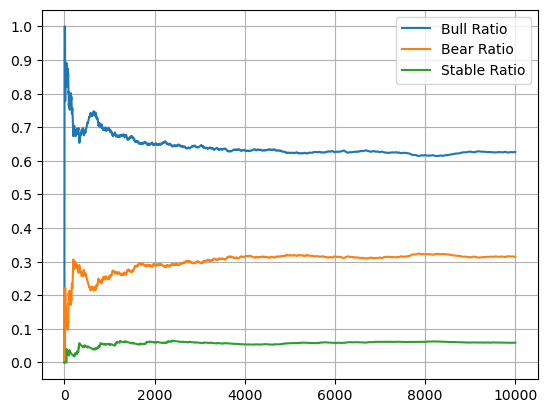

In [5]:
chain = {
    "bull": [0.9, 0.075, 0.025],
    "bear": [0.15, 0.8, 0.05],
    "stable": [0.25, 0.25, 0.5],
}


target, ratio = simulate(10000, 0, chain)

plt.plot(ratio["bull"], label="Bull Ratio")
plt.plot(ratio["bear"], label="Bear Ratio")
plt.plot(ratio["stable"], label="Stable Ratio")

# Better visualization
plt.grid(True)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()

## Monte Carlo integration exercise
Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

How many draws does it take to get the error down to 1 part in a thousand?

## Resolution
We need to $p(x)=1$, so we must have $\frac 2 {\sigma \sqrt{2\pi}}$ to be in the amplitude of the Gaussian. Thus the integral becomes $$\frac{\sigma\sqrt{2\pi}}{2}\int_0^\infty x^3 \frac{2dx}{\sigma\sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right)$$

1.9732604200123485

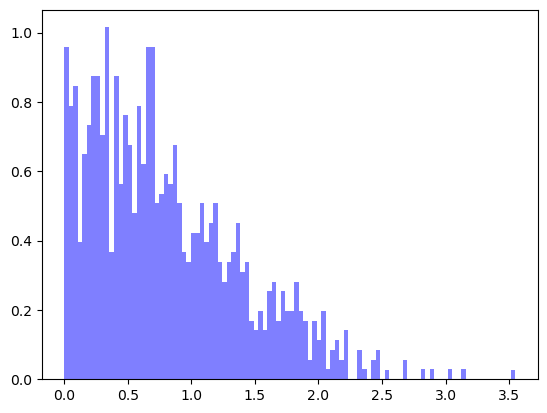

In [6]:
import numpy as np

mu = 0
sigma = 1

xi = abs(np.random.normal(mu, sigma, 1000)) # Automatically adjusts for the half-normal distribution
plt.hist(xi, bins=100, density=True, alpha=0.5, color='blue')

def fun(x):
    return x**3

integral = (sigma * np.sqrt(2* np.pi) / 2) * np.mean(fun(xi))
integral

In [7]:
def check_relative_error(n_draws_list):

    mu = 0
    sigma = 1

    results = []

    fun = lambda x: x**3
    
    for n_draws in n_draws_list:
        xi = abs(np.random.normal(mu, sigma, n_draws)) # Automatically adjusts for the half-normal distribution

        integral = (sigma * np.sqrt(2* np.pi) / 2) * np.mean(fun(xi))
        results.append(integral)
        print(f"Integral for {n_draws} draws: {integral}")
        print(f"Relative error for {n_draws} draws: {np.abs((integral - 2) / 2) * 100:.2f}%")
    return results

n_draws_list = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
check_relative_error(n_draws_list)


Integral for 10 draws: 6.295646542656591
Relative error for 10 draws: 214.78%
Integral for 100 draws: 2.0909288181915815
Relative error for 100 draws: 4.55%
Integral for 1000 draws: 1.92436745267636
Relative error for 1000 draws: 3.78%
Integral for 10000 draws: 2.0870123646017134
Relative error for 10000 draws: 4.35%
Integral for 100000 draws: 1.9830538368036166
Relative error for 100000 draws: 0.85%
Integral for 1000000 draws: 1.998114474121753
Relative error for 1000000 draws: 0.09%
Integral for 10000000 draws: 2.0003939735172986
Relative error for 10000000 draws: 0.02%


[6.295646542656591,
 2.0909288181915815,
 1.92436745267636,
 2.0870123646017134,
 1.9830538368036166,
 1.998114474121753,
 2.0003939735172986]

Roughtly, 10'000 to 100'000 draws are enough to get the error down to one part of a thousand.

## Balls in many dimensions

Do your know the volume of a sphere in N dimensions? It's fun!

Start from the code above we wrote to estimate $\pi$. Generalize it to an artibrary number of dimensions. So, for instance, if N=3 you should get the volume of a sphere, etc etc. 

You will obtain a Monte Carlo estimate. You can compare your findings against the [analytic reusult](https://en.wikipedia.org/wiki/Volume_of_an_n-ball)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/80ca960dcc289606363b3ca5560d921b7c6fea96)

where $\Gamma$ is Euler's Gamma function (conceptually a generalization of factorials to non-integer numbers). 

- Plot N vs the ratio of the volume of the hypersphere to that of the hypercube <-- (Added later??)

**Explore!** Write a code for a generic N, then run it, increase N as much as you can. How many samples do you need for a decent accuracy?

As you will see, the $N\to\infty$ limit is very (very!) surprising.

## Resolution

In [8]:
import numpy as np
from scipy import special

def estimate_volume(N, dim):
    # Suppose we have a hypercube from -1 to 1 in each dimension
    # This is also to accomodate the norm of the points
    points = np.random.uniform(-1, 1, (N, dim))
    
    distances = np.linalg.norm(points, axis=1)
    inside = np.sum(distances < 1)
    
    volume_estimate = (inside / N) * (2 * 1) ** dim
    
    return volume_estimate


def analytic_volume(dim):
    # Volume of a d-dimensional hypersphere
    return (np.pi ** (dim / 2) * 1 ** dim) / special.gamma(dim / 2 + 1)


N = 1000000  # Number of random points
dim = 2 # Dimension of the hypersphere
estim = estimate_volume(N, dim)
real = analytic_volume(dim)
print(f"Estimated volume of {dim}-dimensional hypersphere: {estim}")
print(f"Analytic volume of {dim}-dimensional hypersphere: {real}")

Estimated volume of 2-dimensional hypersphere: 3.137712
Analytic volume of 2-dimensional hypersphere: 3.141592653589793


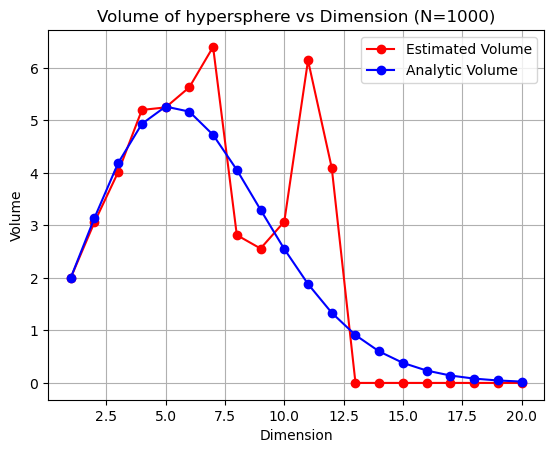

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_graph(N, max_dim):
    dimensions = np.arange(1, max_dim + 1)
    estimated_volumes = []
    analytic_volumes = []
    
    for dim in dimensions:
        volume = estimate_volume(N, dim)
        analytic_vol = analytic_volume(dim)
        estimated_volumes.append(volume)
        analytic_volumes.append(analytic_vol)
    
    plt.plot(dimensions, estimated_volumes, 'ro-', label='Estimated Volume')
    plt.plot(dimensions, analytic_volumes, 'bo-', label='Analytic Volume')
    plt.xlabel('Dimension')
    plt.ylabel('Volume')
    plt.title(f'Volume of hypersphere vs Dimension (N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming estimate_volume and analytic_volume functions are defined)
generate_graph(1000, 20)

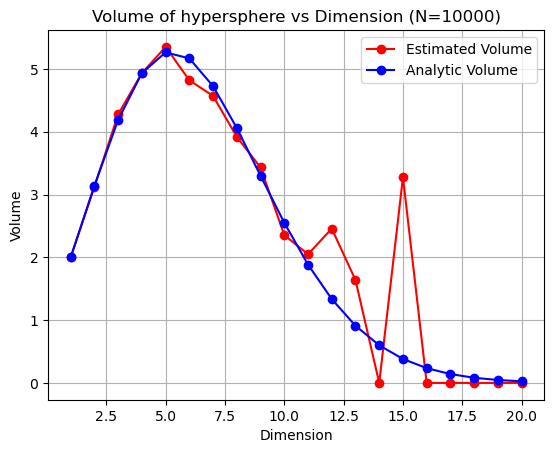

In [10]:
generate_graph(10000, 20)

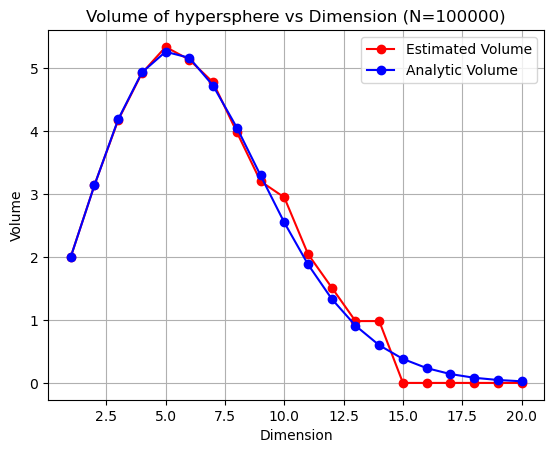

In [11]:
generate_graph(100000, 20)

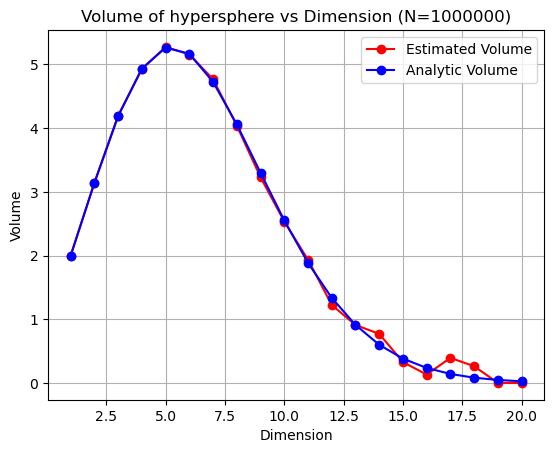

In [12]:
generate_graph(1000000, 20)

### Ratio Hypersphere/Hypercube vs Dimensions

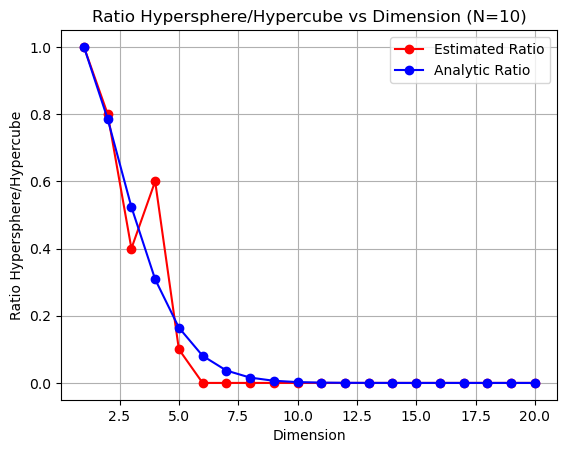

In [14]:
def hypercube_volume(dim):
    return 2 ** dim

def estimate_ratio(N, dim):
    return estimate_volume(N, dim) / hypercube_volume(dim)

def analytic_ratio(dim):
    return ((np.pi ** (dim / 2) * 1 ** dim) / special.gamma(dim / 2 + 1)) / hypercube_volume(dim)

def generate_ratio_graph(N, max_dim):
    dimensions = np.arange(1, max_dim + 1)
    estimated_ratios = []
    analytic_ratios = []
    
    for dim in dimensions:
        volume = estimate_ratio(N, dim)
        analytic_vol = analytic_ratio(dim)
        estimated_ratios.append(volume)
        analytic_ratios.append(analytic_vol)
    
    plt.plot(dimensions, estimated_ratios, 'ro-', label='Estimated Ratio')
    plt.plot(dimensions, analytic_ratios, 'bo-', label='Analytic Ratio')
    plt.xlabel('Dimension')
    plt.ylabel('Ratio Hypersphere/Hypercube')
    plt.title(f'Ratio Hypersphere/Hypercube vs Dimension (N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

generate_ratio_graph(10, 20)

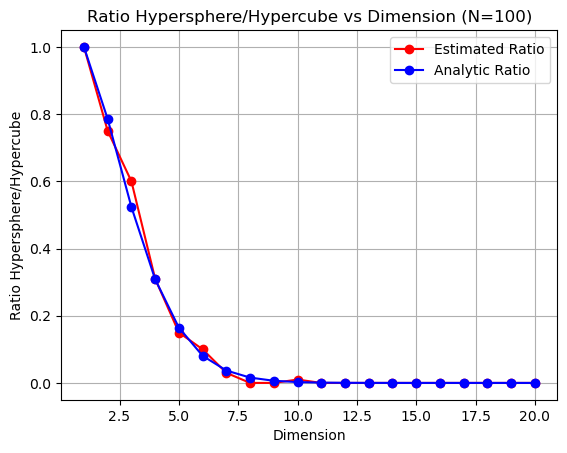

In [15]:
generate_ratio_graph(100, 20)

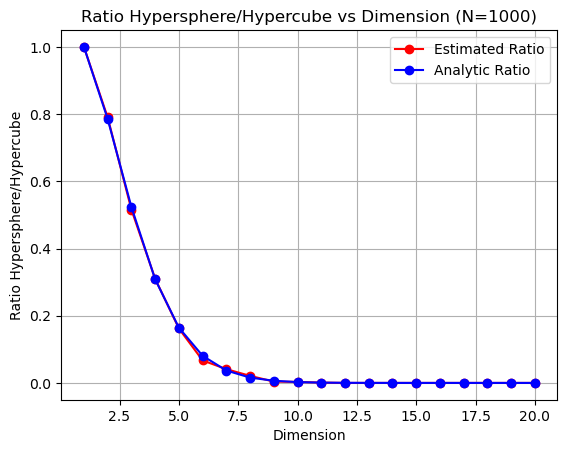

In [16]:
generate_ratio_graph(1000, 20)